In [ ]:
! nvidia-smi

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 此文档介绍NiN网络结构并在手势分类和花分类数据集上实现之

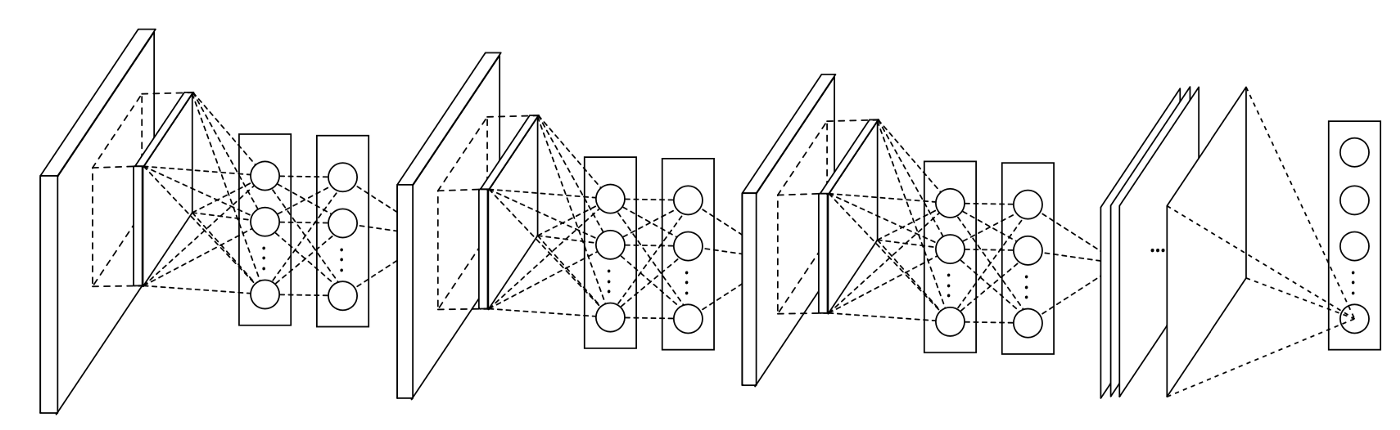

在一般的传统CNN网络中，都是由两部分组成：

（1）一系列的卷积池化操作构成的特征提取层

（2）提取出的特征经过全连接网络构成的分类层

而NiN的核心思想是在传统卷积神经网络（CNN）的基础上引入了一种称为“网络中的网络”（Network in Network）的概念

首先，NiN在卷积层中引入了一种称为1x1卷积（或称为逐点卷积）的结构，1x1卷积的作用在于通过在通道维度上进行卷积来提取特征，并且可以增加非线性。而非传统的卷积是在通道和W，H维度上的操作，这样做的好处是可以在减少参数的同时增加网络的深度和复杂度。通过使用1x1卷积，NiN可以在网络中嵌入更多的网络结构，增加了网络的表征能力，使得网络更能捕捉输入数据的复杂特征。

其次，在设计上并没有使用传统的全连接层，而是引入了一种称为“全局平均池化”（Global Average Pooling）的技术来代替全连接层。简单来说，就是对于前面一系列的卷积池化等操作后，得到的NxHxW的特征图，对于每一个通道维度上的特征图HxW，求全部元素的平均值，即得到Hx1

这一操作取代了全连接层构成的分类网络，全局平均池化的优点在于它不涉及参数，只是简单地对每个特征图的所有值取平均，因此计算量相对较小，可以减少过拟合，并且可以降低模型的复杂度。在一些卷积神经网络中，使用全局平均池化替代全连接层可以有效地减少模型的参数数量和计算负担。

在下面的网络中，在最后一层的NiN结构里面，我们根据分类的类别数量确定了最后一层的通道数量，那么在全局平均池化后，我们得到的每一通道对应的就是每一个分类的类别，如果再经过softmax函数，即可得到每一类分类的置信度。

## model

In [ ]:
"""模型"""

import torch
import torch.nn as nn


class NiNNet(torch.nn.Module):
    def __init__(self, num_classes=1000,init_weights=False):
        super(NiNNet, self).__init__()
        self.NiN1 = torch.nn.Sequential(                                            #[batch,3,224,224]
            nn.Conv2d(3,  96, 11, 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 1),             #[batch,96,54,54]
            nn.ReLU(inplace=True),
            nn.MaxPool2d((3,3),2)
        )
        self.NiN2 = torch.nn.Sequential(                                            #[batch,96,26,26]
            nn.Conv2d(96,  256, 5, 1,2), #[batch,256,26,26]
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((3,3),2)
        )
        self.NiN3 = torch.nn.Sequential(                                      #[batch,256,12,12]
            nn.Conv2d(256, 384, 3, 1, 1), #[batch,384,12,12]
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((3,3),2)
        )
        self.NiN4 = torch.nn.Sequential(

            nn.Dropout(p=0.5),           #[batch,384,5,5]

            nn.Conv2d(384, num_classes, 3, 1, 1), # [batch,10,5,5]
            nn.ReLU(inplace=True),
            nn.Conv2d(num_classes,  num_classes, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_classes,  num_classes, 1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1,1)), # [batch,num_classes,1,1]

            nn.Flatten()  # [batch num_classes]
        )

        if init_weights: # 是否对模型参数初始化
            self._initialize_weights()
            return

    def forward(self,x):
        x = self.NiN1(x)
        x = self.NiN2(x)
        x = self.NiN3(x)
        x = self.NiN4(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
        return




## train

In [ ]:
import torch
from torchvision import transforms, datasets
import json
import tqdm
import sys
import os

data_root = '/content/gdrive/MyDrive/Data'
model = 'NiNNet'
mandate = 'flower'  # 'flower' 'hand'
save_path = model + '-' + mandate + '.pth'
init_weights = True
batch_size = 32
num_epoch = 10
learning_rate = 0.0003


def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    '''数据预处理方法'''
    data_transform = {  # 训练集
        "train": transforms.Compose([transforms.RandomResizedCrop(224),  # 随机裁剪出一个区域,然后resize到224x224大小
                                     transforms.RandomHorizontalFlip(),  # 随机水平翻转
                                     transforms.ToTensor(),  # 图像转换成tensor格式
                                     transforms.Normalize(  # 图像标准化,均值：(0.5,0.5,0.5),标准差：(0.5,0.5,0.5)
                                         (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
        # 测试集
        "val": transforms.Compose([transforms.Resize((224, 224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    }

    '''读取数据集'''
    data = mandate + '_data'
    image_path = os.path.join(data_root, data)  # 'D:/data/hand_data' 'D:/data/flower_data'
    # 确认文件路径存在
    assert os.path.exists(image_path), "{} path does not exist.".format(image_path)
    print("working in {} by {}".format(data, model))

    train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                         transform=data_transform["train"])
    train_num = len(train_dataset)
    validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "val"),
                                            transform=data_transform["val"])
    val_num = len(validate_dataset)
    print("using {} test_images for training, {} test_images for validation.".format(train_num, val_num))

    # 确定分类类别
    mandate_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in mandate_list.items())
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    # 多进程 确定合适的worker数量
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    '''数据加载器'''
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=nw)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw)

    '''设置网络'''
    num_classes = 6 if mandate == 'hand' else 5
    net = NiNNet(num_classes=num_classes, init_weights=init_weights)
    # 将网络发给device
    net.to(device)

    '''训练'''
    loss_function = torch.nn.CrossEntropyLoss()  # 定义损失函数
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  # Adam优化器
    best_acc = 0.0  # 最佳准确率
    for epoch in range(num_epoch):
        running_loss = 0.0
        net.train()  # 将网络设置为训练模式，开启dropout
        train_bar = tqdm.tqdm(train_loader, file=sys.stdout)  # 训练进程进度条显示
        for step, data in enumerate(train_bar):
            images, labels = data

            optimizer.zero_grad()
            outputs = net(images.to(device))
            loss = loss_function(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1, num_epoch, loss)

        '''计算在测试集的准确率'''
        net.eval()  # 在预测时关闭Dropout方法
        acc = 0.0  # 在测试集的准确率 accumulate accurate number / epoch
        with torch.no_grad():
            val_bar = tqdm.tqdm(validate_loader, file=sys.stdout)
            for val_data in val_bar:
                val_images, val_labels = val_data
                outputs = net(val_images.to(device))
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

        val_accurate = acc / val_num  # 统计训练过程的平均损失
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, running_loss / len(train_loader), val_accurate))

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)

    print('Finished Training')


if __name__ == "__main__":
    main()


using cuda:0 device.
working in flower_data by NiNNet
using 3306 test_images for training, 364 test_images for validation.
Using 2 dataloader workers every process
100%|██████████| 12/12 [00:01<00:00,  6.75it/s]
[epoch 1] train_loss: 1.539  val_accuracy: 0.313
100%|██████████| 12/12 [00:01<00:00,  6.79it/s]
[epoch 2] train_loss: 1.483  val_accuracy: 0.412
100%|██████████| 12/12 [00:02<00:00,  5.94it/s]
[epoch 3] train_loss: 1.413  val_accuracy: 0.478
100%|██████████| 12/12 [00:02<00:00,  4.02it/s]
[epoch 4] train_loss: 1.294  val_accuracy: 0.470
100%|██████████| 12/12 [00:02<00:00,  5.48it/s]
[epoch 5] train_loss: 1.197  val_accuracy: 0.448
100%|██████████| 12/12 [00:01<00:00,  6.69it/s]
[epoch 6] train_loss: 1.139  val_accuracy: 0.588
100%|██████████| 12/12 [00:01<00:00,  6.82it/s]
[epoch 7] train_loss: 1.090  val_accuracy: 0.604
100%|██████████| 12/12 [00:01<00:00,  6.60it/s]
[epoch 8] train_loss: 1.032  val_accuracy: 0.640
100%|██████████| 12/12 [00:01<00:00,  6.32it/s]
[epoch 9] tr